In [1]:
#
# Loading libraries
#

import numpy as np

from sklearn.datasets import fetch_openml

import daz

daz.set_daz()
daz.set_ftz()

np.random.seed(1)

In [2]:
#
# Fetching the dataset from server and scale 
# it for our purpose
#

# Fetch the datasets

mnist = fetch_openml("mnist_784")

# Normalize the dataset
mnist_data = mnist.data.values / np.max(mnist.data.values)

# Get Targets
mnist_target = mnist.target.astype(int)

# Convert labels to binaries
mnist_label = np.zeros((mnist_data.shape[0], 10))
for idx in range(mnist_data.shape[0]):
    mnist_label[idx,int(mnist.target[idx])] = 1

# mnist_data = np.load("../mnist_data.np.npy")
# mnist_label = np.load("../mnist_label.np.npy")

# Clean memory space of mnist
mnist = None

/home/alan/.local/conda/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


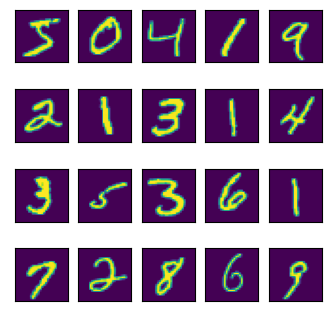

In [3]:
#
# Plot the digits
#

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

N_plot = 20

fig = plt.figure(figsize=(10/2.525, 10/2.525))

for idx in np.arange(N_plot):

    ax = fig.add_subplot(4,5,idx+1)
    ax.set_xticks([])
    ax.set_yticks([])


    im = ax.imshow(mnist_data[idx].reshape((28,28)))
    
#     divider = make_axes_locatable(ax)
    
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    
#     plt.colorbar(im, cax=cax)
#fig.tight_layout()
#fig.savefig("MNIST_example.pdf")

In [4]:
# Number of middle layer

N_y = int(200)

# Number of training samples 

N_train_sample = int(5000)

In [5]:
#
# Cutting the dataset to different matices
#

# Copy the dataset to training and testing

N_test = int(mnist_data.shape[0] * 0.1)

random_list = np.arange(mnist_data.shape[0])
np.random.shuffle(random_list)

mnist_target_training = mnist_label[random_list[:N_train_sample]]
mnist_data_training = mnist_data[random_list[:N_train_sample]]

mnist_target_testing = mnist_label[random_list[(mnist_data.shape[0]-N_test):]]
mnist_data_testing = mnist_data[random_list[(mnist_data.shape[0]-N_test):]]

# Adding age factor for consideration

W_E_xy = np.zeros((N_y, mnist_data.shape[1]))

In [6]:
def y_of_x(x):
    return 0.5*(x + np.abs(x))

# The activation function for y

def y_of_x(x:np.ndarray, W_E_xy:np.ndarray = None, 
           W_I_yy:np.ndarray = None, noise = None
            ):
    
    if W_E_xy is None:
        return 0.5*(x + np.abs(x))

    if len(x.shape) == 1:
        y = np.zeros((W_E_xy.shape[0]))
    else:
        y = np.zeros((W_E_xy.shape[0], x.shape[1]))

    for t in range(20):
        input4y = np.matmul(W_E_xy, x) / np.sqrt(W_E_xy.shape[1])
        if W_I_yy is not None:
            input4y -= np.matmul(W_I_yy, (y)) / np.sqrt(W_I_yy.shape[1])
        if noise is not None:
            input4y += noise
        y += (-y + np.maximum(input4y, 0)) / np.sqrt(5.0)

    return y

def cal_fit_rate(W_E_xy:np.ndarray, 
                 data_sample:np.ndarray, target_sample:np.ndarray,
                 data_test:np.ndarray, target_test:np.ndarray):

    y = y_of_x(data_sample.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    W_yz = np.matmul(y, y.transpose())

    W_yz = np.matmul(y.transpose(), np.linalg.pinv(W_yz))

    W_yz = np.matmul(target_sample.transpose(), W_yz)
    
    
    

    y = y_of_x(data_test.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    z = np.matmul(W_yz, y)

    ans = 1.0 - np.sum(np.heaviside(
                    np.absolute(z.argmax(axis=0) - target_test.argmax(axis=1)) - 0.5
                    , 0)) / float(data_test.shape[0])

    return ans

def update_w(x, w):
    
    w_local = np.copy(w)
    
    x_last = np.zeros(w.shape[1])
    y_last = np.zeros(w.shape[0])
    
    for idx in range(x.shape[0]):
        
        xt = x[idx]
        
#        noise = np.heaviside(np.random.rand(w_local.shape[0]) - 0.95, 0)
        noise = np.random.normal(size=w_local.shape[0])
    
        y = y_of_x(xt, w_local, noise=noise)

        delta_w = np.outer(y, xt)
        
        for i in range(w_local.shape[0]):
            if np.sum(w_local[i]) >= 1.0:
                delta_w[i] = np.zeros_like(delta_w[i])
                
        for i in range(delta_w.shape[1]):
            delta_w[:,i] -= np.mean(delta_w[:,i])

        w_local += 0.02 * delta_w
                    
        for i in range(w_local.shape[1]):
            if np.max(w_local[:,i]) > 1:
                w_local[:,i] /= np.max(w_local[:,i])

        for i in range(w_local.shape[0]):
            if np.max(w_local[i]) < 0:
                w_local[i] = np.zeros_like(w_local[i])
                    
              
    return w_local

In [7]:
W_E_xy = update_w(mnist_data_training, W_E_xy)

In [8]:
from joblib import Parallel, delayed

In [9]:
thenum = np.array([np.argmax(code) for code in mnist_target_testing])

def loop_content(i:int):
    random_list = np.arange(mnist_data.shape[0])
    
    np.random.shuffle(random_list)

    mnist_target_training = mnist_label[random_list[:N_train_sample]]
    mnist_data_training = mnist_data[random_list[:N_train_sample]]
    
    return cal_fit_rate(np.eye(28*28), mnist_data_training, mnist_target_training,
                                 mnist_data_testing[thenum == i], mnist_target_testing[thenum == i])

sample_direct = []
for i in range(10):
    tmp_result = []

    tmp_result = Parallel(n_jobs=-1)(delayed(loop_content)(i) for idx in range(10))

    sample_direct.append(tmp_result)
    print(np.mean(sample_direct[-1]), np.std(sample_direct[-1]), flush=True)

0.9398305084745765 0.0033543339228920793
0.9585677749360613 0.006649616368286458
0.7665680473372781 0.011397254606069957
0.8041265474552958 0.008303377316526295
0.8713872832369942 0.013571510846096984
0.7071428571428571 0.019591136157851408
0.8936872309899571 0.009374115480011276
0.8235772357723578 0.01193335439366071
0.7164705882352941 0.018377058060956856
0.7836257309941521 0.018881736012822167


In [10]:
thenum = np.array([np.argmax(code) for code in mnist_target_testing])

def W_copies_one():
    random_list = np.arange(mnist_data.shape[0])
    
    np.random.shuffle(random_list)

    mnist_target_training = mnist_label[random_list[:N_train_sample]]
    mnist_data_training = mnist_data[random_list[:N_train_sample]]
        
    W_E_xy = np.zeros((N_y, mnist_data.shape[1]))

    W_E_xy = update_w(mnist_data_training, W_E_xy)
    
    return [W_E_xy, mnist_data_training, mnist_target_training]

W_copies = Parallel(n_jobs=-1)(delayed(W_copies_one)() for idx in range(10))

sample_compet = []
for i in range(10):
    tmp_result = []
    for idx in range(10):
        
        tmp_result.append(cal_fit_rate(W_copies[idx][0], W_copies[idx][1], W_copies[idx][2],
                                 mnist_data_testing[thenum == i], mnist_target_testing[thenum == i]))
                
    sample_compet.append(tmp_result)
    print(np.mean(sample_compet[-1]), np.std(sample_compet[-1]), flush=True)

0.9502824858757062 0.006826579646098623
0.9812020460358054 0.002496064104340556
0.889792899408284 0.006072300518276257
0.8894085281980744 0.012010387869569795
0.8924855491329481 0.014697320387388585
0.9045454545454543 0.008796244924768869
0.9582496413199426 0.006000150262934434
0.9261517615176151 0.004076316790377072
0.8611764705882352 0.01674405332645916
0.8966374269005847 0.012896195432748763


In [11]:
thenum = np.array([np.argmax(code) for code in mnist_target_testing])

def loop_content(i:int, shape):
    random_list = np.arange(mnist_data.shape[0])
    
    np.random.shuffle(random_list)

    mnist_target_training = mnist_label[random_list[:N_train_sample]]
    mnist_data_training = mnist_data[random_list[:N_train_sample]]
    
    return cal_fit_rate(np.random.normal(size=shape), mnist_data_training, mnist_target_training,
                                 mnist_data_testing[thenum == i], mnist_target_testing[thenum == i])

sample_normal = []
for i in range(10):
    tmp_result = []

    tmp_result = Parallel(n_jobs=-1)(delayed(loop_content)(i, W_E_xy.shape) for idx in range(10))
    
    sample_normal.append(tmp_result)
    print(np.mean(sample_normal[-1]), np.std(sample_normal[-1]), flush=True)

0.933050847457627 0.013116595216094809
0.970076726342711 0.0044001663770039025
0.8183431952662721 0.013538533951062184
0.8297111416781293 0.019797873287837206
0.8552023121387282 0.01846999457649763
0.7672077922077922 0.026775381714310636
0.9308464849354376 0.010558605160960747
0.8715447154471546 0.012951548125039042
0.758235294117647 0.015114900185328925
0.8124269005847953 0.019647839174167375


In [12]:
np.mean(sample_normal, axis=1)

array([0.93305085, 0.97007673, 0.8183432 , 0.82971114, 0.85520231,
       0.76720779, 0.93084648, 0.87154472, 0.75823529, 0.8124269 ])

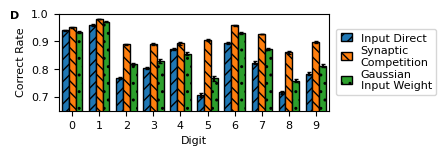

In [13]:

fig, ax = plt.subplots(1,1,figsize=(4.33,1.44))

ax.bar(np.arange(10)-0.25025, np.mean(sample_direct, axis=1), yerr=np.std(sample_direct, axis=1)/np.sqrt(10.), 
       width=0.25, label="Input Direct", hatch='///', edgecolor='black', capsize=1.5)
ax.bar(np.arange(10), np.mean(sample_compet, axis=1), yerr=np.std(sample_compet, axis=1)/np.sqrt(10.), 
       width=0.25, label="Synaptic\nCompetition", hatch='\\\\\\', edgecolor='black', capsize=1.5)
ax.bar(np.arange(10)+0.25025, np.mean(sample_normal, axis=1), yerr=np.std(sample_normal, axis=1)/np.sqrt(10.), 
       width=0.25, label="Gaussian\nInput Weight", hatch='..', edgecolor='black', capsize=1.5)

ax.set_xticks(np.arange(0,10))
ax.set_yticks(np.arange(0,1.1,0.1))

ax.set_ylim((0.65,1))
ax.set_xlim((-0.5,9.5))

ax.tick_params(labelsize=8)

ax.set_xlabel("Digit", fontsize=8)
ax.set_ylabel("Correct Rate", fontsize=8)

ax.legend(fontsize=8,borderpad=0.4, 
                labelspacing=0.2, handlelength=1, bbox_to_anchor=(1.005, 0.9))

ax.text(-0.18,0.95,"D",weight="bold",transform=ax.transAxes,fontsize=8)

plt.subplots_adjust(left=0.125,
                    bottom=0.275, 
                    right=0.75, 
                    top=0.95, 
                    wspace=0.5, 
                    hspace=0.35)

plt.savefig("Fig04_3low.pdf")